Prepared By

Zhijie He, Dhivin Joshua Nelson

### Build graphlets by hand



**Network flows:**

format: srcIP protocol dstIP sPort dPort

14.112.37.26 17 14.112.37.29 138 138

14.112.37.26 17 14.112.37.33 80 80

14.112.37.27 6 14.112.37.34 167 80

14.112.37.28 6 14.112.37.29 443 443

14.112.37.26 17 14.112.37.33 443 80

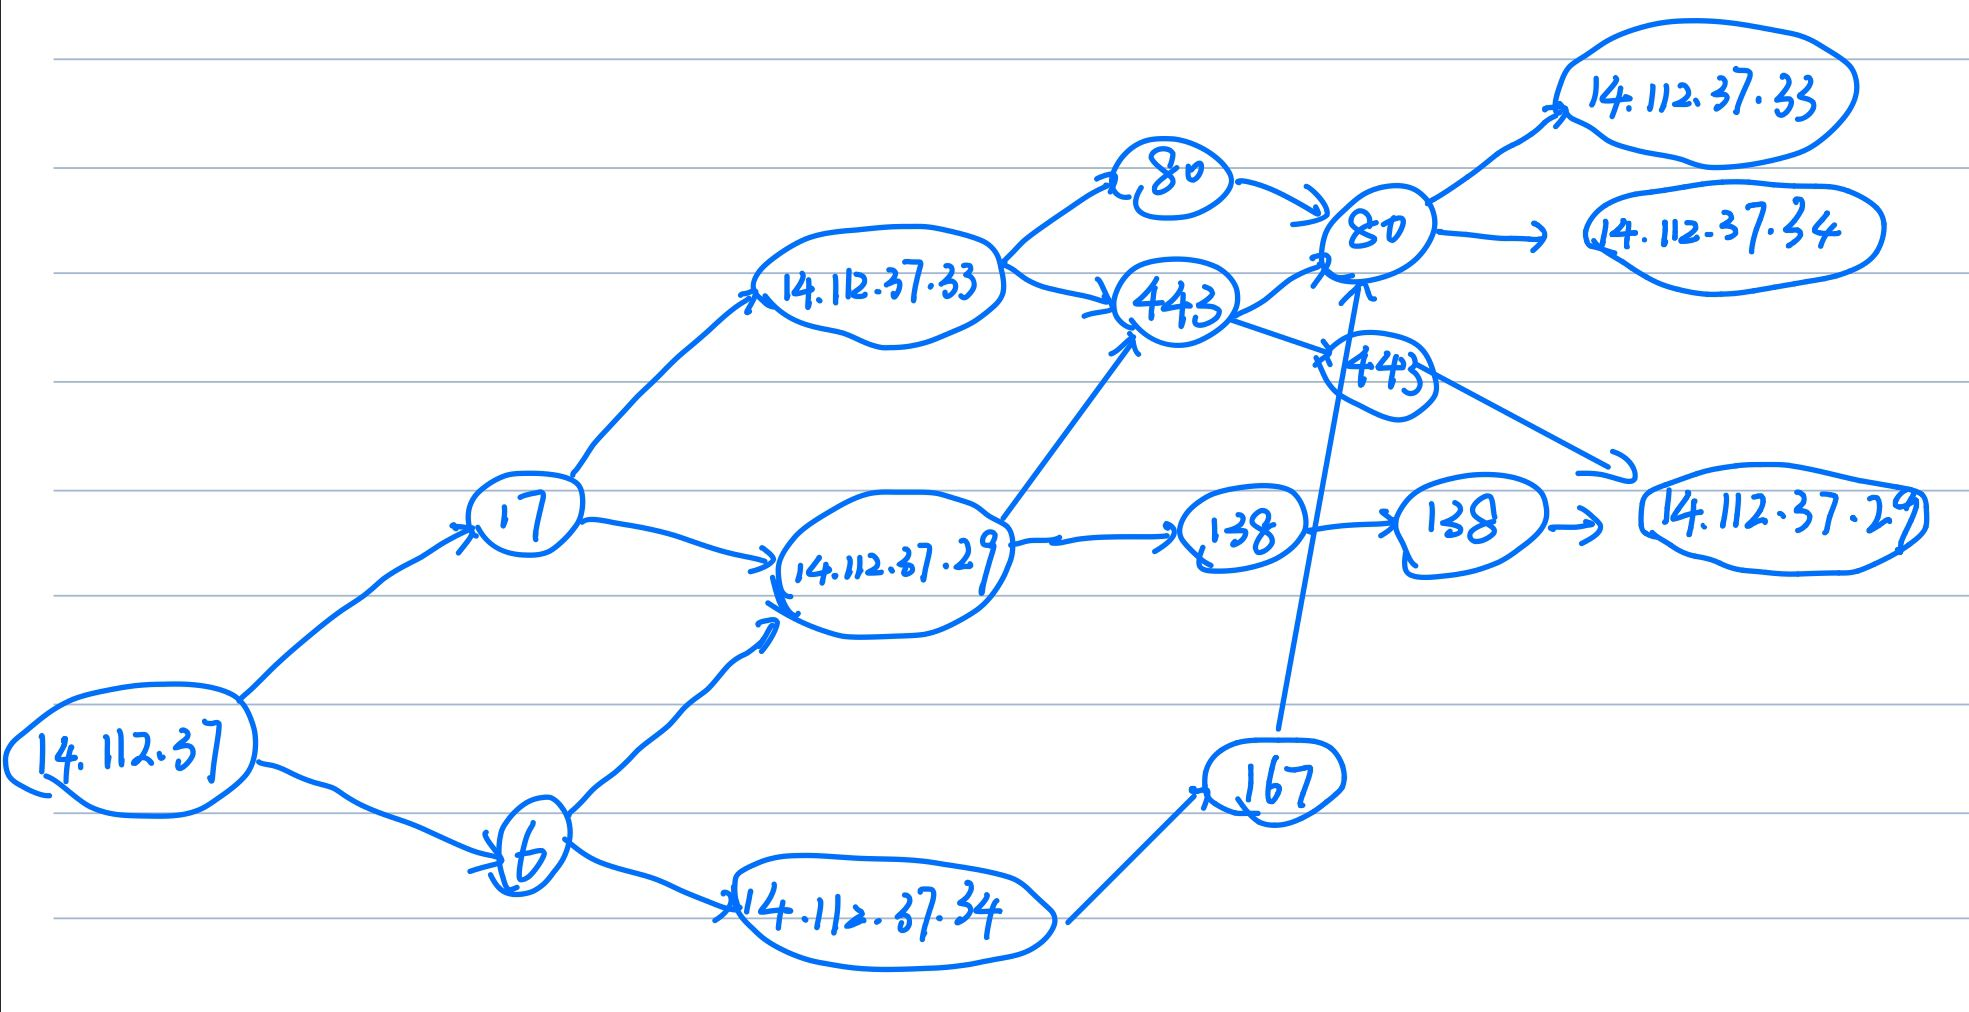

### Plot Graphlets using annotated-trace data

Import necessary libraries

In [18]:
#Drawing Libraries
import networkx as nx
import matplotlib.pyplot as plt 
#Machine Learning
from sklearn import svm
#Basic Manipulation
import pandas as pd
import numpy as np
#hide the warnings
import warnings
#Cal time
from time import time

Import Dataset

In [2]:
#Import Dataset
df= pd.read_csv('/content/annotated-trace.csv',header=None)

#rename column
df.columns = ['srcIP','dstIP','protocol','srcPort','dstPort','label']

#add end-host
df['endHost'] = df['dstIP']

#change the column order
df = df[['srcIP','protocol','dstIP','srcPort','dstPort','endHost','label']]

#add layer at the end of each column   cause in different column has same value
df['srcIP'] = df['srcIP'].astype(str)+":1"
df['protocol'] = df['protocol'].astype(str)+":2"
df['dstIP'] = df['dstIP'].astype(str)+":3"
df['srcPort'] = df['srcPort'].astype(str)+":4"
df['dstPort'] = df['dstPort'].astype(str)+":5"
df['endHost'] = df['endHost'].astype(str)+":6"

df.head()

,srcIP,protocol,dstIP,srcPort,dstPort,endHost,label
0,569:1,6:2,513:3,80:4,68:5,513:6,normal
1,96:1,17:2,455:3,68:4,80:5,455:6,normal
2,472:1,17:2,353:3,68:4,22:5,353:6,normal
3,165:1,17:2,572:3,23:4,23:5,572:6,normal
4,441:1,17:2,188:3,79:4,53:5,188:6,normal


In [4]:
# check the unique values number of each column
n = df.nunique(axis=0) 
n

srcIP       1001
protocol       4
dstIP       1000
srcPort        9
dstPort       35
endHost     1000
label          2
dtype: int64




#### Develop function to build graphlets

In [5]:
def Graphlet(network_flows, plot=True,label=True):

  #extract each column unique value
  nodes_srcIP = network_flows['srcIP'].unique()
  nodes_protocol = network_flows['protocol'].unique()
  nodes_dstIP = network_flows['dstIP'].unique()
  nodes_srcPort = network_flows['srcPort'].unique()
  nodes_dstPort = network_flows['dstPort'].unique()
  nodes_endHost = network_flows['endHost'].unique()

  if label:
    nodes_label = network_flows['label'].unique()

  #Create Graph
  G=nx.DiGraph()
  
  #Add edges to Graph
  if label:
    for index, row in network_flows.iterrows():
      G.add_edges_from([(row['srcIP'],row['protocol']),
            (row['protocol'],row['dstIP']),
            (row['dstIP'],row['srcPort']),
            (row['srcPort'],row['dstPort']),
            (row['dstPort'],row['endHost']),
            (row['endHost'],row['label'])])
  else:
    for index, row in network_flows.iterrows():
      G.add_edges_from([(row['srcIP'],row['protocol']),
            (row['protocol'],row['dstIP']),
            (row['dstIP'],row['srcPort']),
            (row['srcPort'],row['dstPort']),
            (row['dstPort'],row['endHost'])]) 

  
  #calculate the position improving layout
  if label:
    pos_nodes = [nodes_srcIP,nodes_protocol,nodes_dstIP,nodes_srcPort,nodes_dstPort,nodes_endHost,nodes_label]
    pos={}
    for index,nodes in enumerate(pos_nodes):
      for num, node in enumerate(nodes):
        pos[node]=(index,len(nodes)/2*0.5-num*0.5)

  else:
    
    pos_nodes = [nodes_srcIP,nodes_protocol,nodes_dstIP,nodes_srcPort,nodes_dstPort,nodes_endHost]
    pos={}
    for index,nodes in enumerate(pos_nodes):
      for num, node in enumerate(nodes):
        pos[node]=(index,len(nodes)/2*0.5-num*0.5)

  if plot:
    plt.figure()
    nx.draw(G,pos,with_labels=True)
  return G

#### Plot Graphlets

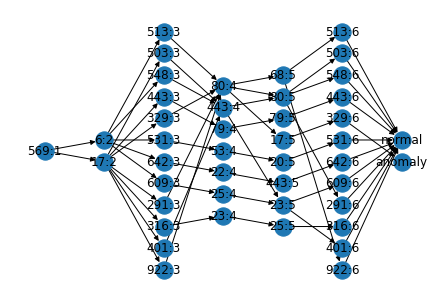

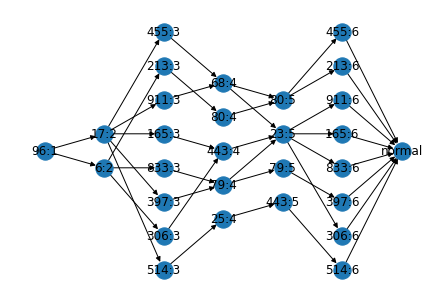

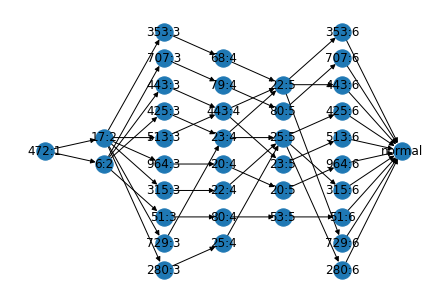

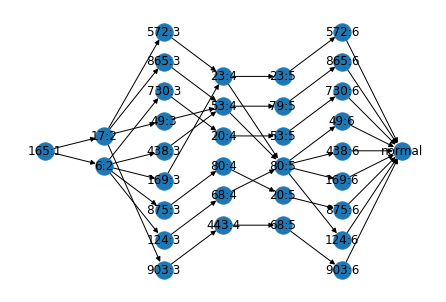

In [6]:
#hide all the warning
warnings.filterwarnings('ignore')

#get the flows corresponding to unique machine ip
nodes_srcIP = df['srcIP'].unique()
test_nodes_srcIP = nodes_srcIP[0:4]

for node in test_nodes_srcIP:
  test_data = df[df['srcIP']==node]
  Graphlet(test_data,label = True)

### Random Walk kernel and Shortest Path method

Import Necessary Libraries

In [7]:
import itertools
import gc
from sklearn import svm

#### RWK

In [8]:
# the random walk kernel
def kernel1(a1):
    a0=np.zeros((a1.shape[0],a1.shape[0]))
    mylist=list(np.unique(np.nonzero(a1)))
    for i in mylist:
        a0[i,i]=1
    a2=a1*a1
    a3=a2*a1  
    a4=a3*a1
    F=a0+a1+a2+a3+a4;
    return F

#### Cal Feature Vector

In [292]:
def FeatureValues(data,flag=True, label=True):

  G = Graphlet(data, plot=False,label=label)
  df1=pd.DataFrame()
  mylist = []

  srcIP = list(set(data['srcIP']))
  #significant nodes
  protocols = list(set(data['protocol'])) #protocol
  dstIPs = list(set(data['dstIP'])) #dstIP
  dstPorts = list(set(data['dstPort'])) #dstPort
  endHosts = list(set(data['endHost'])) #dstIP endHost

  TNode=[]
  tmp='srcIP'
  com=2;
  for j in protocols:
      x=int(G.in_degree(j))
      y=int(G.out_degree(j))
      if (x+y>com):
          tmp=j
          com=x+y
  TNode.append(com)

  com=1;
  for j in dstIPs:
      y=int(G.out_degree(j))
      if (y>com):
          tmp=j
          com=y
  TNode.append(com)

  com=1;
  for j in dstPorts:
      y=int(G.in_degree(j))
      if (y>com):
          tmp=j
          com=y
  TNode.append(com)   

  com=2;
  for j in endHosts:
      x=int(G.in_degree(j))
      y=int(G.out_degree(j))
      if (x+y>com):
          tmp=j
          com=x+y
  TNode.append(com)
  
  G.clear()
  del G


  #profile graphlets
  df2=data;

  for index, row  in data.iterrows():
      tmp=0
      if (row["protocol"]==TNode[0]):
          tmp=tmp+1
      if (row["dstIP"]==TNode[1]):
          tmp=tmp+1
      if (row["dstPort"]==TNode[2]):
          tmp=tmp+1
      if (row["endHost"]==TNode[3]):
          tmp=tmp+1
      if (tmp<2):
          df2.drop(index)

  #the basis graph includes all the elements in the train dataset

  D = nx.DiGraph()
  D.add_edges_from([edge for edge in zip(df2['srcIP'],data['protocol'])])
  D.add_edges_from([edge for edge in zip(df2['protocol'],data['dstIP'])])
  D.add_edges_from([edge for edge in zip(df2['dstIP'],data['dstPort'])])
  D.add_edges_from([edge for edge in zip(df2['dstPort'],data['endHost'])])
  if label:
    D.add_edges_from([edge for edge in zip(df2['endHost'],data['label'])])


  #calculate the feature values for each graphlet
  tm=[]
  if flag: # use the random walk kernel
      a1=nx.adj_matrix(D)
      cd=kernel1(a1)
      tm=cd.flatten().tolist()
  else: #use the shortest path kernel
      cd=nx.floyd_warshall_numpy(D)
      tm=cd.flatten().tolist()
  
  #D.remove_edges_from(list(D.edges()))
  out = list(itertools.chain.from_iterable(tm))
  mylist.append(out)

  df1=pd.concat([df1, df2], axis=0, ignore_index=True) #the significant records  

  del D
  #print(mylist)
  return df1,mylist

In [293]:
#get the flows corresponding to unique label
label = df['label'].unique()
df_normal = df[df['label']==label[0]]
df_anomaly = df[df['label']==label[1]]

#get the flows corresponding to unique machine ip
nodes_normal_srcIP = df_normal['srcIP'].unique()
nodes_anomaly_srcIP = df_anomaly['srcIP'].unique()

flag = True #Use RWK

sub1=pd.DataFrame()
mylist1 = []
#calculate the normal samples
for node in nodes_normal_srcIP:
  cut_data = df_normal[df_normal['srcIP']==node]
  tmp_sub,list1=FeatureValues(cut_data, flag)
  sub1=pd.concat([sub1,tmp_sub])
  mylist1=mylist1+list1

sub2=pd.DataFrame()
mylist2 = []
#calculate the anomaly samples
for node in nodes_anomaly_srcIP:
  cut_data = df_anomaly[df_anomaly['srcIP']==node]
  tmp_sub,list2=FeatureValues(cut_data, flag)
  sub2=pd.concat([sub2,tmp_sub])
  mylist2=mylist2+list2

In [294]:
X= mylist1 + mylist2
t=np.append(np.zeros(len(mylist1)),np.ones(len(mylist2)))
y=np.transpose([t])

In [295]:
MAX_LENGTH = 0
#find the max length size
for x in X:
  if MAX_LENGTH < len(x):
    MAX_LENGTH = len(x)

tmp = []

#resize the list
for x in X:
  if len(x) <= MAX_LENGTH:
    x = x + [0.0]*(MAX_LENGTH-len(x))
    tmp.append(x[0:MAX_LENGTH+1])
X = np.array(tmp)

#### Bulid SVM model

In [296]:
classif = svm.SVC(kernel='linear')

start = time()
classif.fit(X[0:1059,0:1000], y.ravel())
t11=(time() - start)

In [297]:
def my_kernel(X, Y):
   return np.dot(X, Y.T)

In [298]:
clf = svm.SVC(kernel=my_kernel)
start = time()
clf.fit(X[:,0:1000], y.ravel())
t13=(time() - start)

In [299]:
print(t11,"----time----",t13)

0.04298567771911621 ----time---- 0.05828046798706055


### Unannotated Trace

Import the data

In [236]:
#Import not annotated data
df_unannotated = pd.read_csv('/content/not-annotated-trace.csv',header = None)

#rename column
df_unannotated.columns = ['srcIP','dstIP','protocol','srcPort','dstPort']

#add end-host
df_unannotated['endHost'] = df_unannotated['dstIP']

#change the column order
df_unannotated = df_unannotated[['srcIP','protocol','dstIP','srcPort','dstPort','endHost']]

#add layer at the end of each column   cause in different column has same value
df_unannotated['srcIP'] = df_unannotated['srcIP'].astype(str)+":1"
df_unannotated['protocol'] = df_unannotated['protocol'].astype(str)+":2"
df_unannotated['dstIP'] = df_unannotated['dstIP'].astype(str)+":3"
df_unannotated['srcPort'] = df_unannotated['srcPort'].astype(str)+":4"
df_unannotated['dstPort'] = df_unannotated['dstPort'].astype(str)+":5"
df_unannotated['endHost'] = df_unannotated['endHost'].astype(str)+":6"

df_unannotated.head()

,srcIP,protocol,dstIP,srcPort,dstPort,endHost
0,36:1,17:2,240:3,53:4,53:5,240:6
1,1211:1,17:2,240:3,53:4,80:5,240:6
2,852:1,6:2,574:3,23:4,53:5,574:6
3,404:1,6:2,765:3,22:4,25:5,765:6
4,729:1,6:2,586:3,20:4,443:5,586:6


#### Plot graphlets

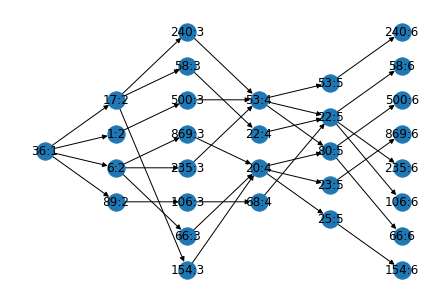

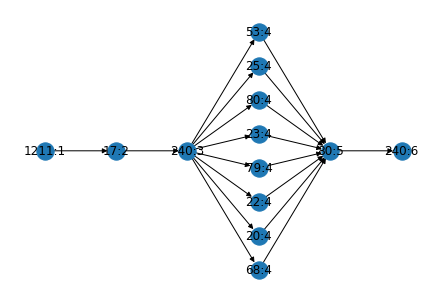

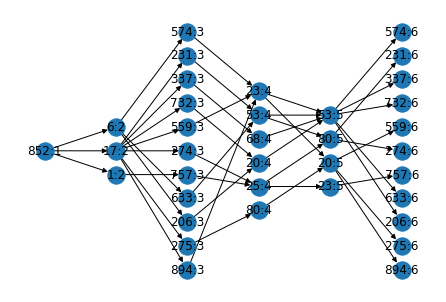

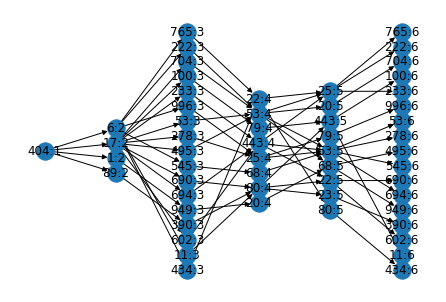

In [242]:
#get the flows corresponding to unique machine ip
nodes_srcIP = df_unannotated['srcIP'].unique()
#set the displayed graphlets number
graphlets_number = 4
test_nodes_srcIP = nodes_srcIP[0:graphlets_number]

for node in test_nodes_srcIP:
  test_data = df_unannotated[df_unannotated['srcIP']==node]
  Graphlet(test_data,label = False)

In [247]:
flag = True

sub=pd.DataFrame()
FV = []
#calculate the normal samples
for node in nodes_srcIP:
  cut_data = df_unannotated[df_unannotated['srcIP']==node]
  tmp_sub,list1=FeatureValues(cut_data, flag, label = False)
  sub=pd.concat([sub,tmp_sub])
  FV=FV+list1

In [260]:
MAX_LENGTH = 0
#find the max length size
for x in FV:
  if MAX_LENGTH < len(x):
    MAX_LENGTH = len(x)

tmp = []
#append
for x in FV:
  if len(x) <= MAX_LENGTH:
    x = x + [0.0]*(MAX_LENGTH-len(x))
    tmp.append(x[0:MAX_LENGTH+1])
FV = np.array(tmp)

In [280]:
X_unannotated = FV[:,0:1000]

#### prediction

In [282]:
y_pred = clf.predict(X_unannotated)
y_pred

array([0., 1., 0., ..., 0., 0., 0.])

### Classification evaluation

In [288]:
# Split dataset in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [289]:
from sklearn import svm
clf = svm.SVC(kernel=my_kernel)
clf.fit(X_train[:,0:1000], y_train.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function my_kernel at 0x7f5a22d7e8c0>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [290]:
from sklearn.metrics import classification_report

print(classification_report(y_test, clf.predict(X_test[:,0:1000])))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       299
         1.0       1.00      1.00      1.00        19

    accuracy                           1.00       318
   macro avg       1.00      1.00      1.00       318
weighted avg       1.00      1.00      1.00       318



#### True Label

Confusion matrix, without normalization
[[299   0]
 [  0  19]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


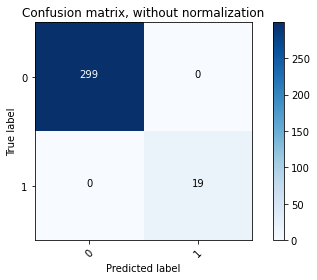

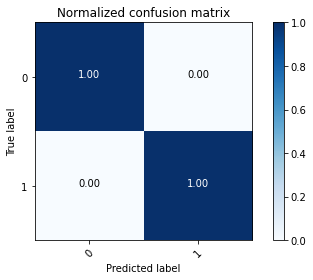

In [291]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Class_names
class_names = ['0', '1']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test[:,0:1000]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()